# <Font color = 'indianred'>**Load Libraries/Install Software**

In [ ]:
if 'google.colab' in str(get_ipython()):
    from google.colab import drive
    drive.mount('/content/drive')

    !pip install torchtext --upgrade -qq
    !pip install torchmetrics -qq
    !pip install torchinfo -qq

    basepath = '/content/drive/MyDrive/BUAN-6342'



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Importing PyTorch library for tensor computations and neural network modules
import torch
import torch.nn as nn
import torch.nn.functional as F

# For working with textual data vocabularies and for displaying model summaries
from torchtext.vocab import vocab
from torchinfo import summary

# General-purpose Python libraries for random number generation and numerical operations
import random
import numpy as np

# Utilities for efficient serialization/deserialization of Python objects and for element tallying
import joblib
from collections import Counter

# For creating lightweight attribute classes and for partial function application
from types import SimpleNamespace
from functools import partial

# For filesystem path handling, generating and displaying confusion matrices, and date-time manipulations
from pathlib import Path
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from datetime import datetime

# For plotting and visualization
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
import ast
from sklearn.preprocessing import MultiLabelBinarizer
# HammingDistance is useful for evaluating multi-label classification problems.
from torchmetrics import HammingDistance
import torchmetrics
from  torchmetrics.functional.classification import multilabel_f1_score, multilabel_hamming_distance
from sklearn.metrics import accuracy_score, f1_score, hamming_loss
from torchmetrics.functional.classification import multilabel_accuracy



# <Font color = 'indianred'>**Specify Project Folders**

In [ ]:
base_folder = Path(basepath)
data_folder = base_folder/'0_Data'
model_folder = base_folder
custom_functions = base_folder/'0_Python_Scripts'

# <Font color = 'indianred'>**Data Preparation**

##  <Font color = 'indianred'>**Load cleaned arrays from indianredd files using joblib**

In [ ]:
df = data_folder / 'df_multilabel_hw_cleaned.joblib'

In [ ]:
data = joblib.load(df)

In [64]:
type(data)

pandas.core.frame.DataFrame

In [ ]:
data.head()

,cleaned_text,Tags,Tag_Number
0,asp query stre dropdown webpage follow control...,c# asp.net,"[0, 9]"
1,run javascript code server java code want run ...,java javascript,"[1, 3]"
2,linq sql throw exception row find change hi li...,c# asp.net,"[0, 9]"
3,run python script php server run nginx web ser...,php python,"[2, 7]"
4,advice write function m try write function res...,javascript jquery,"[3, 5]"


In [ ]:
X = data['cleaned_text'].values
y = data['Tag_Number'].values
print(type(X), type(y))
print(y.dtype)
print(X.dtype)

<class 'numpy.ndarray'> <class 'numpy.ndarray'>
object
object


In [ ]:
# Convert 'Tag_Number' column to a list of integers
data['Tag_Number_list'] = data['Tag_Number'].apply(ast.literal_eval)

In [ ]:
data.head()

,cleaned_text,Tags,Tag_Number,Tag_Number_list
0,asp query stre dropdown webpage follow control...,c# asp.net,"[0, 9]","[0, 9]"
1,run javascript code server java code want run ...,java javascript,"[1, 3]","[1, 3]"
2,linq sql throw exception row find change hi li...,c# asp.net,"[0, 9]","[0, 9]"
3,run python script php server run nginx web ser...,php python,"[2, 7]","[2, 7]"
4,advice write function m try write function res...,javascript jquery,"[3, 5]","[3, 5]"


In [ ]:
# Initialize MultiLabelBinarizer
mlb = MultiLabelBinarizer(classes=np.arange(10))

y_final = data['Tag_Number_list'].values

# Transform the 'Tag_Number' column into one-hot encoded labels
y_one_hot = mlb.fit_transform(y_final)
y_one_hot


array([[1, 0, 0, ..., 0, 0, 1],
       [0, 1, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 1],
       ...,
       [0, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 1],
       [0, 0, 0, ..., 0, 0, 0]])

In [ ]:
y = y_one_hot

In [ ]:
# Split the data into train (60%), validation (20%), and test (20%) sets
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)


In [ ]:
print(len(X_train), len(X_valid), len(X_test))

28456 9485 9486


## <Font color = 'indianred'>**Custom Dataset Class**

In [ ]:
class CustomDataset(torch.utils.data.Dataset):

    def __init__(self, X, y):
        # Converting the feature data to a NumPy array for consistency
        self.X = np.array(X)

        # Storing the target labels
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        # Retrieve the text and corresponding label from the dataset using the index
        texts = self.X[idx]
        labels = self.y[idx]

        # Packing them into a tuple before returning
        sample = (labels, texts)

        return sample

In [ ]:
trainset = CustomDataset(X_train, y_train)
validset = CustomDataset(X_valid, y_valid)
testset = CustomDataset(X_test, y_test)

In [ ]:
trainset[1][1]

'drop default selection cause search begin search page textboxe user enter datum search   date textboxe date range enter   drop select date field want filter date range textboxe enable default   select date field drop enter date   default drop selection   blank select date field change date field drop ok   select datefield drop switch default blank trigger search   want happen   want search happen click search button    protect void ddldatetype_selectedindexchanged(object sender eventargs e               ddldatetype selectedvalue =                       txtsearchenddate enabled = true              txtsearchstartdate enabled = true                                          txtsearchenddate text =              txtsearchstartdate text =              txtsearchenddate enable = false              txtsearchstartdate enable = false                 tell stop search run switch default selection drop   comment code result    select default search start select default search trigger'

In [ ]:
trainset[1][0]

array([1, 0, 0, 0, 0, 0, 0, 0, 0, 1])

## <Font color = 'indianred'>**Create Vocab**

In [ ]:
def get_vocab(dataset, min_freq=1):
    # Initialize a counter object to hold token frequencies
    counter = Counter()

    # Update the counter with tokens from each text in the dataset
    for (l_, text) in dataset:
        counter.update(str(text).split())

    # Create a vocabulary using the counter object
    # Tokens that appear fewer times than `min_freq` are excluded
    my_vocab = vocab(counter, min_freq=min_freq)

    # Insert a '<unk>' token at index 0 to represent unknown words
    my_vocab.insert_token('<unk>', 0)

    # Set the default index to 0
    # This ensures that any unknown word will be mapped to '<unk>'
    my_vocab.set_default_index(0)

    return my_vocab


In [ ]:
stack_vocab = get_vocab(trainset, min_freq=2)

In [ ]:
len(stack_vocab)

90287

In [ ]:
stack_vocab.get_itos()[0:5]

['<unk>', 'rearrange', 'order', 'list', 'web']

## <Font color = 'indianred'>**Collate_fn for Data Loaders**

In [ ]:
# Creating a function that will be used to get the indices of words from vocab
def text_pipeline(x, vocab):
    """Converts text to a list of indices using a vocabulary dictionary"""
    return [vocab[token] for token in str(x).split()]

In [ ]:
def collate_batch(batch, my_vocab):
    labels, texts = zip(*batch)
    labels = torch.tensor(labels, dtype=torch.float64) #dtype updated
    list_of_list_of_indices = [text_pipeline(text, my_vocab) for text in texts]

    offsets = [0] + [len(i) for i in list_of_list_of_indices]
    offsets = torch.tensor(offsets[:-1]).cumsum(dim=0)

    # Concatenate all text indices into a single tensor
    texts = torch.cat([torch.tensor(i, dtype=torch.int64) for i in list_of_list_of_indices])

    return (texts, offsets), labels



# <Font color = 'indianred'>**Model**
embedding_layer-->linear--> ReLU -->dropout --> batch norm --> linear-->ReLu-->Dropout--> batchnorm ---> linear layer

In [ ]:
class CustomBlock(nn.Module):
    def __init__(self, input_dim, output_dim, drop_prob):

        super().__init__()

        self.layers = nn.Sequential(
            nn.Linear(input_dim, output_dim),
            nn.BatchNorm1d(num_features=output_dim),
            nn.ReLU(),
            nn.Dropout(p=drop_prob),

        )
    def forward(self, x):
      return self.layers(x)



In [ ]:
class CustomMLP(nn.Module):
    def __init__(self, vocab_size, embedding_dim, hidden_dim1, hidden_dim2, drop_prob1, drop_prob2, num_outputs):
        super().__init__()

        self.embedding_bag = nn.EmbeddingBag(vocab_size, embedding_dim)
        self.layers = nn.Sequential(
            CustomBlock(embedding_dim , hidden_dim1, drop_prob1),
            CustomBlock(hidden_dim1, hidden_dim2, drop_prob2),
            nn.Linear(hidden_dim2, num_outputs)
        )

    def forward(self, input_tuple):
        data, offsets = input_tuple
        embed_out = self.embedding_bag(data, offsets)
        out = self.layers(embed_out)

        return out

# <Font color = 'indianred'>**Model Training Functions**




## <Font color = 'indianred'>**Step Function**

In [ ]:
def step(inputs, targets, model, device, loss_function=None, optimizer=None, hamming_distance=None, threshold=0.0):

    # Move the model and data to the device
    model = model.to(device)
    inputs = tuple(input_tensor.to(device) for input_tensor in inputs)
    targets = targets.to(device)

    # Step 1: Forward pass to get the model's predictions
    outputs = model(inputs)

    # Step 2: Compute the loss using the provided loss function
    if loss_function:
        loss = loss_function(outputs, targets)

    # Step 3 and 4: Perform backward pass and update model parameters if an optimizer is provided
    if optimizer:
        optimizer.zero_grad()
        loss.backward()
        # Clip gradients before the optimizer step
        torch.nn.utils.clip_grad_value_(model.parameters(), clip_value=10.0)
        # Update model parameters
        optimizer.step()

    # Step 5: Apply thresholding to the model's outputs
    with torch.no_grad():
        outputs = (torch.sigmoid(outputs) >= threshold).float()

    # Step 6: Update the Hamming Distance metric (if provided)
    if hamming_distance:
        hamming_distance.update(outputs, targets)

    # Step 7: Return relevant metrics
    if loss_function:
        return loss, outputs, hamming_distance
    else:
        return outputs, targets


## <Font color = 'indianred'>**Train_Epoch Function**

In [ ]:
def train_epoch(train_loader, model, device, loss_function, optimizer, train_hamming_distance):

    # Set the model to training mode
    model.train()

    # Initialize variables to track running training loss and correct predictions
    running_train_loss = 0.0
    tr_epoch_metric = None

    # Iterate over all batches in the training data
    for i, (inputs, targets) in enumerate(train_loader):
        # Perform a forward and backward pass, updating model parameters
        loss, _, epoch_hamming_distance = step(inputs, targets, model, device, loss_function, optimizer, train_hamming_distance)

        # Update running loss counter
        running_train_loss += loss.item()

    # Compute average loss and accuracy for the entire training set
    train_loss = running_train_loss / len(train_loader)

    if epoch_hamming_distance is not None:
        tr_epoch_metric = epoch_hamming_distance.compute().item()
        epoch_hamming_distance.reset()


    return train_loss, tr_epoch_metric


## <Font color = 'indianred'>**Val_Epoch Function**


In [ ]:
def val_epoch(valid_loader, model, device, loss_function, train_hamming_distance):
    # Set the model to evaluation mode
    model.eval()

    # Initialize variables to track running validation loss and correct predictions
    running_val_loss = 0.0
    val_epoch_metric = None

    # with torch.no_grad():
    # Iterate over all batches in the validation data
    for i, (inputs, targets) in enumerate(valid_loader):
        # Perform a forward pass to get loss and number of correct predictions
        loss, _, val_epoch_hamming_distance = step(inputs, targets, model, device, loss_function, optimizer=None, hamming_distance=train_hamming_distance)

        # Update running loss and correct predictions counter
        running_val_loss += loss.item()

    # Compute average loss and accuracy for the entire validation set
    val_loss = running_val_loss / len(valid_loader)

    if val_epoch_hamming_distance is None:
      print("This is none")

    if val_epoch_hamming_distance is not None:
        val_epoch_metric = val_epoch_hamming_distance.compute().item()
        val_epoch_hamming_distance.reset()

    # val_epoch_metric = val_epoch_hamming_distance.compute().item()
    # val_epoch_hamming_distance.reset()


    return val_loss, val_epoch_metric


## <Font color = 'indianred'>**Train Function**

In [ ]:
def train(train_loader, valid_loader, model, optimizer, loss_function, epochs, device):
    # Initialize lists to store metrics for each epoch
    train_loss_history = []
    valid_loss_history = []


    train_hamming_distance = HammingDistance(task="multilabel", num_labels=10).to(device)

    # Loop over the number of specified epochs
    for epoch in range(epochs):
        # Train model on training data and capture metrics
        train_loss, train_metric = train_epoch(
            train_loader, model, device, loss_function, optimizer, train_hamming_distance)

        # Validate model on validation data and capture metrics
        valid_loss, val_metric = val_epoch(
            valid_loader, model, device, loss_function, train_hamming_distance)

        # Store metrics for this epoch
        train_loss_history.append(train_loss)
        valid_loss_history.append(valid_loss)


        # Output epoch-level summary
        print(f"Epoch {epoch+1}/{epochs}")
        print(f'Train Loss: {train_loss:.4f} | Train Hamming Distance: {train_metric:.4f}')
        print(f'Val Loss: {valid_loss:.4f} | Val Hamming Distance: {val_metric:.4f}')
        print()


    return train_loss_history, train_metric, valid_loss_history, val_metric


# <Font color = 'indianred'>**Hyperparameters**

In [ ]:
hyperparameters = SimpleNamespace(
    # model Parameters
    EMBED_DIM=300,
    VOCAB_SIZE=len(stack_vocab),
    OUTPUT_DIM=10,
    HIDDEN_DIM1=200,
    HIDDEN_DIM2=100,
    DROP_PROB1=0.5,
    DROP_PROB2=0.5,
    NUM_OUTPUTS=10,

    # training
    EPOCHS=5,
    BATCH_SIZE=128,
    LEARNING_RATE=0.001,
    WEIGHT_DECAY=0.000,
    CLIP_TYPE='value',
    CLIP_VALUE=10,
    PATIENCE=5,
)


# <Font color = 'indianred'>**Training Configuration**

In [ ]:
# Fix seed value
SEED = 2345
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

collate_fn = partial(collate_batch, my_vocab=stack_vocab)

# Data Loader
train_loader = torch.utils.data.DataLoader(trainset, batch_size=hyperparameters.BATCH_SIZE, shuffle=True,
                                           collate_fn=collate_fn, num_workers=2)
valid_loader = torch.utils.data.DataLoader(validset, batch_size=hyperparameters.BATCH_SIZE, shuffle=False,
                                           collate_fn=collate_fn,  num_workers=2)
test_loader = torch.utils.data.DataLoader(testset, batch_size=hyperparameters.BATCH_SIZE,   shuffle=False,
                                          collate_fn=collate_fn,  num_workers=2)

# Binary cross entropy with Logit loss function for multilabel classification
loss_function =  nn.BCEWithLogitsLoss()

# model
stack_imdb = CustomMLP(vocab_size=hyperparameters.VOCAB_SIZE,
                       embedding_dim=hyperparameters.EMBED_DIM,
                       hidden_dim1=hyperparameters.HIDDEN_DIM1,
                       hidden_dim2=hyperparameters.HIDDEN_DIM2,
                       drop_prob1=hyperparameters.DROP_PROB1,
                       drop_prob2=hyperparameters.DROP_PROB2,
                       num_outputs=hyperparameters.NUM_OUTPUTS)

def init_weights(m):
    if type(m) == nn.Linear:
        torch.nn.init.kaiming_normal_(m.weight)
        torch.nn.init.zeros_(m.bias)


# apply initialization recursively  to all modules
stack_imdb.apply(init_weights)

# Intialize stochiastic gradient descent optimizer
optimizer = torch.optim.AdamW(stack_imdb.parameters(),
                             lr=hyperparameters.LEARNING_RATE,

                             )

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# <Font color = 'indianred'>**Sanity Check**
- Check the loss without any training. For Cross entropy the expected value will be log(number of classes)

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
for input_, targets  in train_loader:

    # move inputs and outputs to GPUs
    stack_imdb = stack_imdb.to(device)

    input_ = tuple(input_tensor.to(device)
                            for input_tensor in input_)
    targets = targets.to(device)

    stack_imdb.eval()
    # Forward pass
    output = stack_imdb(input_)
    output = output.float()
    loss = loss_function(output, targets)
    print(f'Actual loss: {loss}')
    break

print(f'Expected Theoretical loss: {np.log(2)}')

Actual loss: 0.6804529574706977
Expected Theoretical loss: 0.6931471805599453


# <Font color = 'indianred'>**Training Model**

In [ ]:
# Call the train function to train the model
import warnings
warnings.filterwarnings("ignore")

train_losses, train_hamming_dis, valid_losses, valid_hamming_dis = train(
    train_loader, valid_loader, stack_imdb, optimizer, loss_function, hyperparameters.EPOCHS, device
)


Epoch 1/5
Train Loss: 0.3515 | Train Hamming Distance: 0.7919
Val Loss: 0.1919 | Val Hamming Distance: 0.7924

Epoch 2/5
Train Loss: 0.1918 | Train Hamming Distance: 0.7919
Val Loss: 0.1502 | Val Hamming Distance: 0.7924

Epoch 3/5
Train Loss: 0.1572 | Train Hamming Distance: 0.7919
Val Loss: 0.1339 | Val Hamming Distance: 0.7924

Epoch 4/5
Train Loss: 0.1346 | Train Hamming Distance: 0.7919
Val Loss: 0.1214 | Val Hamming Distance: 0.7924

Epoch 5/5
Train Loss: 0.1196 | Train Hamming Distance: 0.7919
Val Loss: 0.1145 | Val Hamming Distance: 0.7924



In [ ]:
# Call the train function to train the model
import warnings
warnings.filterwarnings("ignore")


train_losses, train_hamming_dis, valid_losses, valid_hamming_dis = train(
    train_loader, valid_loader, stack_imdb, optimizer, loss_function, hyperparameters.EPOCHS, device
)


Epoch 1/5
Train Loss: 0.1083 | Train Hamming Distance: 0.7919
Val Loss: 0.1092 | Val Hamming Distance: 0.7924

Epoch 2/5
Train Loss: 0.0965 | Train Hamming Distance: 0.7919
Val Loss: 0.1051 | Val Hamming Distance: 0.7924

Epoch 3/5
Train Loss: 0.0879 | Train Hamming Distance: 0.7919
Val Loss: 0.1033 | Val Hamming Distance: 0.7924

Epoch 4/5
Train Loss: 0.0808 | Train Hamming Distance: 0.7919
Val Loss: 0.1011 | Val Hamming Distance: 0.7924

Epoch 5/5
Train Loss: 0.0747 | Train Hamming Distance: 0.7919
Val Loss: 0.1042 | Val Hamming Distance: 0.7924



# <Font color = 'indianred'>**Plot Losses Metrics**


In [ ]:
def plot_history(train_losses, train_metrics, val_losses=None, val_metrics=None):

    epochs = range(1, len(train_losses) + 1)

    # Plot training and validation losses
    plt.figure()
    plt.plot(epochs, train_losses, label="Train")
    if val_losses:
      plt.title('Train Vs Validation Loss')
      plt.plot(epochs, val_losses, label="Validation")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()



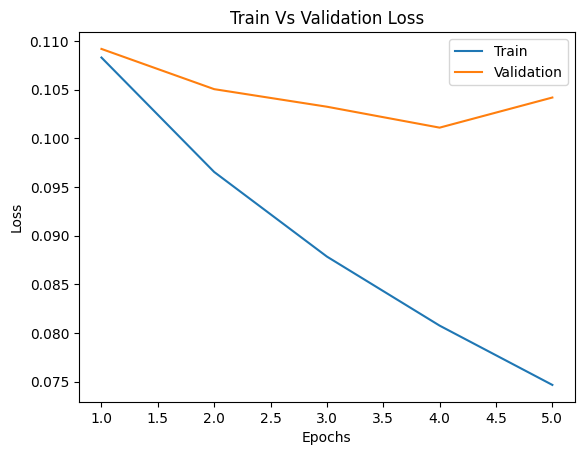

In [ ]:
plot_history(train_losses, train_hamming_dis, valid_losses, valid_hamming_dis)

# <Font color = 'indianred'>**Model Checkpointing**

In [ ]:
# Get the current timestamp in the format "YYYY-MM-DD_HH-MM-SS"
timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

# Define a suffix for the file name
suffix = 'twolayer'

# Combine the timestamp and suffix to create the file path
path = model_folder / f'{timestamp}_{suffix}.pt'
path

PosixPath('/content/drive/MyDrive/BUAN-6342/2023-09-25_04-26-12_twolayer.pt')

In [ ]:
# Save the model's state dictionary to the specified file path
torch.save(stack_imdb.state_dict(), path)


In [ ]:
# Create an instance of the model with the same architecture
my_model = CustomMLP(vocab_size=hyperparameters.VOCAB_SIZE,
                       embedding_dim=hyperparameters.EMBED_DIM,
                       hidden_dim1=hyperparameters.HIDDEN_DIM1,
                       hidden_dim2=hyperparameters.HIDDEN_DIM2,
                       drop_prob1=hyperparameters.DROP_PROB1,
                       drop_prob2=hyperparameters.DROP_PROB2,
                       num_outputs=hyperparameters.NUM_OUTPUTS)

# Load the model's state dictionary from the specified checkpoint file
checkpoint = torch.load(path)

# Load the saved state dictionary into the model
my_model.load_state_dict(checkpoint)


<All keys matched successfully>

# <Font color = 'indianred'>**Get Accuracy, Predictions**

In [ ]:
def get_acc_pred(data_loader, model, device, multilabel=True, threshold=0.0):

    model = model.to(device)
    model.eval()

    # Create empty tensors to store predictions and actual labels
    predictions = torch.Tensor().to(device)
    y = torch.Tensor().to(device)

    # Iterate over batches from data loader
    with torch.no_grad():
        for inputs, targets in data_loader:
            # Move inputs and targets to the device
            inputs = tuple(input_tensor.to(device) for input_tensor in inputs)
            targets = targets.to(device)

            # Perform a forward pass to get the model's outputs
            outputs = model(inputs)

            # Choose the label with maximum probability
            if multilabel:
                outputs = (torch.sigmoid(outputs) > threshold).float()


            # Add the predicted labels and actual labels to their respective tensors
            predictions = torch.cat((predictions, outputs if multilabel else predicted))
            y = torch.cat((y, targets))

    # Return tuple containing predictions and actual labels
    return predictions, y


In [ ]:

%%time
predictions_test, target_test = get_acc_pred(test_loader, my_model, device)
predictions_train, target_train = get_acc_pred(train_loader, my_model, device)
predictions_valid, target_valid = get_acc_pred(valid_loader, my_model, device)


CPU times: user 667 ms, sys: 293 ms, total: 960 ms
Wall time: 2.72 s


## Calculating the hamming distance for test, train and validation data

In [ ]:

metric_hd = multilabel_hamming_distance
train_hamdis = metric_hd(predictions_train, target_train, num_labels=10)
valid_hamdis = metric_hd(predictions_valid, target_valid, num_labels=10)
test_hamdis = metric_hd(predictions_test, target_test, num_labels=10)

In [ ]:
# Print Hammoimng Distance
print('Test hamming distance', test_hamdis )
print('Train hamming distance', train_hamdis )
print('Valid hamming distance', valid_hamdis )

Test hamming distance tensor(0.7922, device='cuda:0')
Train hamming distance tensor(0.7919, device='cuda:0')
Valid hamming distance tensor(0.7924, device='cuda:0')


## Calculating the F1 score for hamming distance for test, train and validation data

In [ ]:
metric_f1 = multilabel_f1_score
f1_valid = metric_f1(predictions_valid, target_valid, num_labels=10)
f1_test = metric_f1(predictions_test, target_test,num_labels=10)
f1_train = metric_f1(predictions_train, target_train, num_labels=10)

# Print Test Accuracy
print('Test f1 - score', f1_test * 100)
print('Train f1 - score', f1_train * 100)
print('Valid f1 - score', f1_valid * 100)


Test f1 - score tensor(30.6745, device='cuda:0')
Train f1 - score tensor(30.5824, device='cuda:0')
Valid f1 - score tensor(30.5475, device='cuda:0')


# <Font color = 'blue'>*************THE END*************